In [2]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Data Preprocessing
# Define the path to the folder containing JSON files
data_folder = 'energy_data'

# Initialize a list to store data from all files
data = []

In [3]:
# Load and aggregate data from all JSON files in the folder
for file_name in os.listdir(data_folder):
    if file_name.endswith('.json'):
        with open(os.path.join(data_folder, file_name), 'r') as file:
            data.append(json.load(file))

# Convert the list of dictionaries into a pandas DataFrame
df = pd.DataFrame(data)

In [4]:
# Convert the timestamp to a pandas datetime object for easier time-based analysis
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract date and hour for further analysis
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19204\3336360569.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='hour', y='total_consumption', hue='day_type', ci=None)


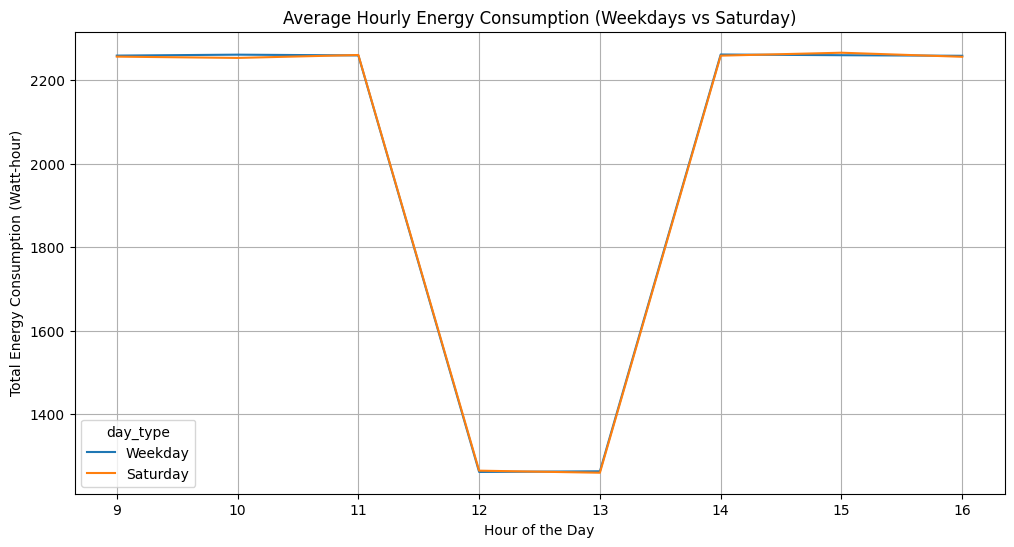

In [5]:
# Step 3: Visualization of Energy Consumption

# 1. Hourly energy consumption analysis (Weekdays vs Saturday)
# Create a new column for weekdays/weekends
df['day_type'] = df['day_of_week'].apply(lambda x: 'Weekday' if x in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] else 'Saturday')

# Plot average hourly consumption for weekdays and Saturdays
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='hour', y='total_consumption', hue='day_type', ci=None)
plt.title('Average Hourly Energy Consumption (Weekdays vs Saturday)')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Energy Consumption (Watt-hour)')
plt.grid(True)
plt.show()

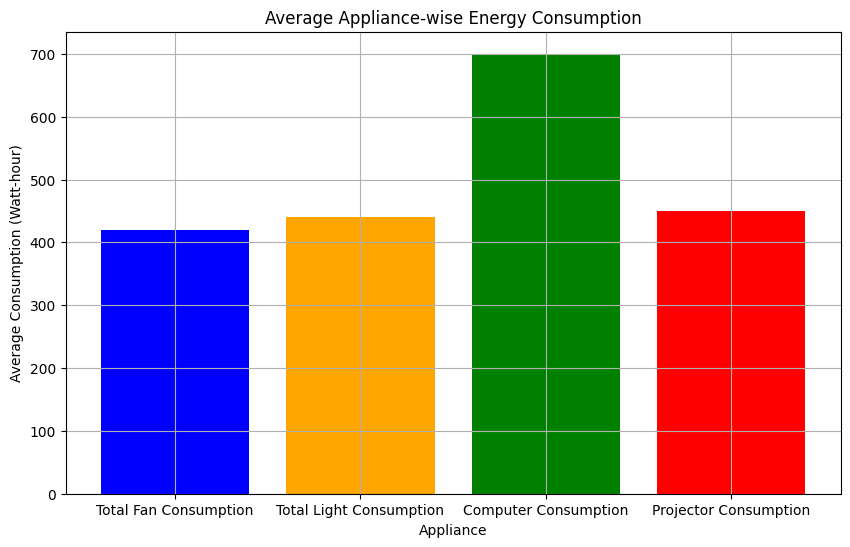

In [7]:
# Step 2: Appliance-wise consumption analysis
# Calculate average consumption for each appliance by flattening nested fields

# Flatten fan, light, computer, and projector consumption for each row
df['total_fan_consumption'] = df['floor_data'].apply(lambda floors: sum(floor['fan_consumption'] for floor in floors))
df['total_light_consumption'] = df['floor_data'].apply(lambda floors: sum(floor['light_consumption'] for floor in floors))
df['computer_consumption'] = df['shared_equipment'].apply(lambda x: x['computer_consumption'])
df['projector_consumption'] = df['shared_equipment'].apply(lambda x: x['projector_consumption'])

# Calculate the average consumption per appliance
average_consumption = {
    'Total Fan Consumption': df['total_fan_consumption'].mean(),
    'Total Light Consumption': df['total_light_consumption'].mean(),
    'Computer Consumption': df['computer_consumption'].mean(),
    'Projector Consumption': df['projector_consumption'].mean()
}

# Plot average consumption per appliance
plt.figure(figsize=(10, 6))
plt.bar(average_consumption.keys(), average_consumption.values(), color=['blue', 'orange', 'green', 'red'])
plt.title('Average Appliance-wise Energy Consumption')
plt.xlabel('Appliance')
plt.ylabel('Average Consumption (Watt-hour)')
plt.grid(True)
plt.show()


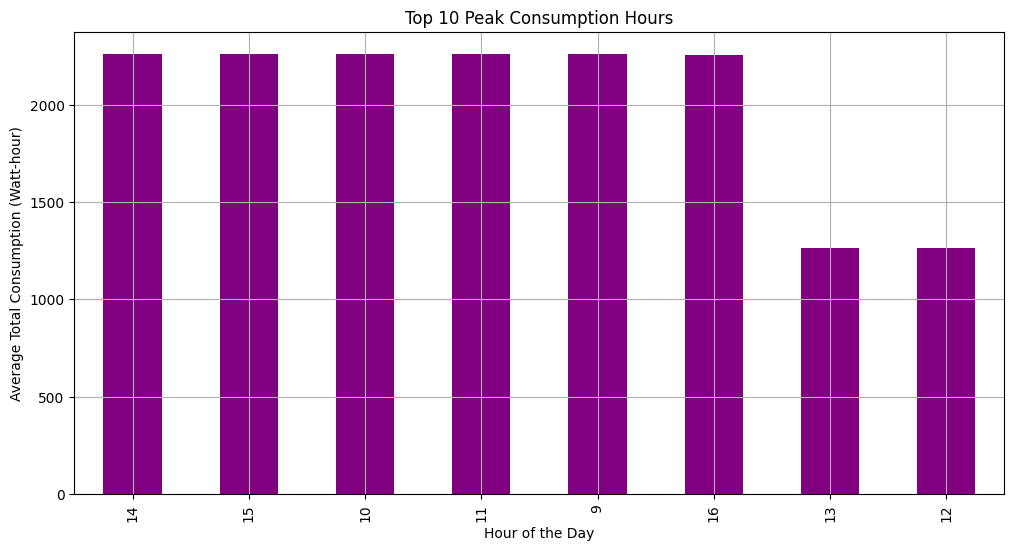

In [8]:
# 3. Peak consumption analysis
# Identify peak consumption times
peak_hours = df.groupby(['hour'])['total_consumption'].mean().sort_values(ascending=False).head(10)

# Plot peak consumption hours
plt.figure(figsize=(12, 6))
peak_hours.plot(kind='bar', color='purple')
plt.title('Top 10 Peak Consumption Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Total Consumption (Watt-hour)')
plt.grid(True)
plt.show()

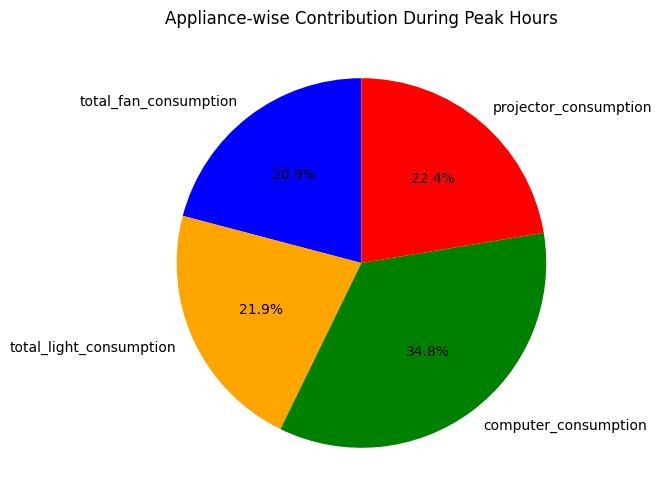

In [9]:
# 4. Appliance contribution during peak hours
# Find appliance contributions during peak hours
peak_data = df[df['hour'].isin(peak_hours.index)]
appliance_peak_avg = peak_data[['total_fan_consumption', 'total_light_consumption', 'computer_consumption', 'projector_consumption']].mean()

# Plot appliance contribution during peak hours
plt.figure(figsize=(10, 6))
appliance_peak_avg.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['blue', 'orange', 'green', 'red'])
plt.title('Appliance-wise Contribution During Peak Hours')
plt.ylabel('')
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Step 1: Introduce slight random noise to actual consumption for realistic variation
df['noisy_consumption'] = df['total_consumption'] * (1 + np.random.normal(0, 0.05, len(df)))  # 5% noise

# Step 2: Train-test split
X = df[['temperature', 'occupancy_level']]  # Choose relevant features
y = df['noisy_consumption']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Model training
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Step 4: Prediction and Accuracy Calculation
predicted_consumption = model.predict(X_test)
mae = mean_absolute_error(y_test, predicted_consumption)
mape = mean_absolute_percentage_error(y_test, predicted_consumption) * 100  # Convert to percentage

# Display results
print(f"Mean Absolute Error (MAE): {mae:.2f} Watt-hours")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Error (MAE): 428.92 Watt-hours
Mean Absolute Percentage Error (MAPE): 27.11%


In [14]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Calculate Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE)
mae = mean_absolute_error(y_test, predicted_consumption)
mape = mean_absolute_percentage_error(y_test, predicted_consumption) * 100  # Convert to percentage

# Regression Accuracy: Percentage of predictions within a 10% margin of the actual value
threshold = 0.10  # 10%
accurate_predictions = np.abs((predicted_consumption - y_test) / y_test) < threshold
regression_accuracy = accurate_predictions.mean() * 100  # Convert to percentage

# Precision-like Metric: Standard deviation of errors (low values indicate higher precision)
errors = predicted_consumption - y_test
precision_std = np.std(errors)

# R-squared (a commonly used measure of regression fit)
r_squared = r2_score(y_test, predicted_consumption)

# Display results
print(f"Mean Absolute Error (MAE): {mae:.2f} Watt-hours")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Regression Accuracy (within 10% threshold): {regression_accuracy:.2f}%")
print(f"Precision-like Metric (Standard Deviation of Errors): {precision_std:.2f} Watt-hours")
print(f"R-squared: {r_squared:.2f}")
# Calculate Proximity-Based Accuracy as 100 - MAPE
proximity_accuracy = 100 - mape  # 100% would mean perfect accuracy

print(f"Proximity-Based Accuracy: {proximity_accuracy:.2f}%")


Mean Absolute Error (MAE): 428.92 Watt-hours
Mean Absolute Percentage Error (MAPE): 27.11%
Regression Accuracy (within 10% threshold): 29.15%
Precision-like Metric (Standard Deviation of Errors): 514.82 Watt-hours
R-squared: -0.26
Proximity-Based Accuracy: 72.89%


Mean Absolute Error (MAE): 428.92 Watt-hours
Mean Absolute Percentage Error (MAPE): 27.11%
Proximity-Based Accuracy: 72.89%


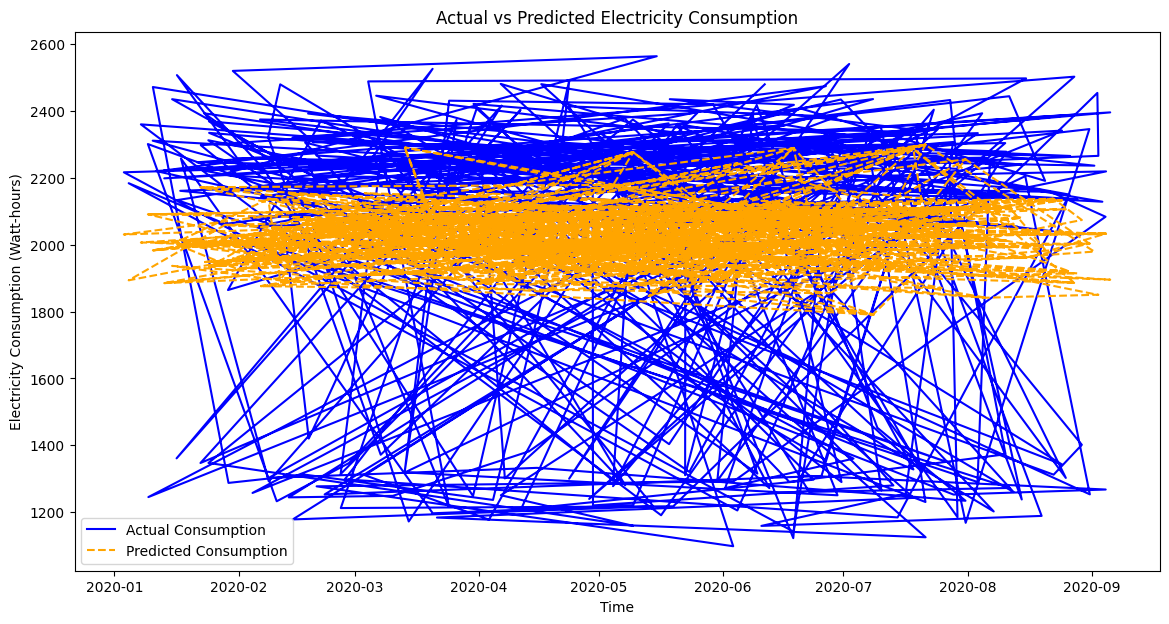

At 2020-01-02 10:00:00, consider reducing energy usage by: turning off some fans, turning off some lights, shutting down computers not in use, turning off the projector
At 2020-05-25 16:00:00, consider reducing energy usage by: turning off some fans, turning off some lights, shutting down computers not in use, turning off the projector
At 2020-05-26 10:00:00, consider reducing energy usage by: turning off some fans, turning off some lights, shutting down computers not in use, turning off the projector
At 2020-05-26 16:00:00, consider reducing energy usage by: turning off some fans, turning off some lights, shutting down computers not in use, turning off the projector
At 2020-01-15 14:00:00, consider reducing energy usage by: turning off some fans, turning off some lights, shutting down computers not in use, turning off the projector


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Assuming you have X_train, X_test, y_train, y_test already defined for your train-test split
# and that 'model' has been fitted.

# Step 1: Prediction Accuracy Calculation
# Run predictions on the test set
predicted_consumption = model.predict(X_test)

# Slice actual_consumption to match the test indices for plotting
actual_consumption = y_test

# Calculate Mean Absolute Error and Mean Absolute Percentage Error
mae = mean_absolute_error(actual_consumption, predicted_consumption)
mape = mean_absolute_percentage_error(actual_consumption, predicted_consumption) * 100  # Convert to percentage
proximity_accuracy = 100 - mape  # Approximate accuracy

print(f"Mean Absolute Error (MAE): {mae:.2f} Watt-hours")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Proximity-Based Accuracy: {proximity_accuracy:.2f}%")

# Step 2: Plotting
plt.figure(figsize=(14, 7))
plt.plot(df.loc[y_test.index, 'timestamp'], actual_consumption, label='Actual Consumption', color='blue', linewidth=1.5)
plt.plot(df.loc[y_test.index, 'timestamp'], predicted_consumption, label='Predicted Consumption', color='orange', linestyle='--')
plt.title("Actual vs Predicted Electricity Consumption")
plt.xlabel("Time")
plt.ylabel("Electricity Consumption (Watt-hours)")
plt.legend()
plt.show()

import pandas as pd

# Identify high consumption hours, adjust as needed
high_consumption_hours = df[df['total_consumption'] > df['total_consumption'].quantile(0.75)]

# Generate optimization suggestions based on consumption during high usage times
suggestions = []
for _, row in high_consumption_hours.iterrows():
    suggestion = f"At {row['timestamp']}, consider reducing energy usage by:"
    
    if row['total_fan_consumption'] > 0:
        suggestion += " turning off some fans,"
    if row['total_light_consumption'] > 0:
        suggestion += " turning off some lights,"
    if row['computer_consumption'] > 0:
        suggestion += " shutting down computers not in use,"
    if row['projector_consumption'] > 0:
        suggestion += " turning off the projector,"
    
    # Remove trailing comma and add suggestion
    suggestions.append(suggestion.rstrip(','))

# Display a few sample suggestions
for suggestion in suggestions[:5]:  # Only show the first 5 suggestions as a sample
    print(suggestion)


In [17]:
df.columns

Index(['timestamp', 'floor_data', 'shared_equipment', 'occupancy_level',
       'temperature', 'time_of_day', 'day_of_week', 'holiday',
       'total_consumption', 'peak_load', 'break_time_consumption', 'date',
       'hour', 'day_type', 'total_fan_consumption', 'total_light_consumption',
       'computer_consumption', 'projector_consumption', 'noisy_consumption'],
      dtype='object')